# Transitory Shocks and Aggregate Saving Rate
Created on Thursday March 22 12:39:11 2018

@author: Tongli Zhang

Based on code from Derin Aksit

In [1]:
import sys 
import os
sys.path.insert(0, os.path.abspath('../../')) #Path to ConsumptionSaving folder
sys.path.insert(0, os.path.abspath('../../../'))
sys.path.insert(0, os.path.abspath('../../../cstwMPC')) #Path to cstwMPC folder
sys.path.insert(0, os.path.abspath('../../../ConsumptionSaving'))

import SetupParamsCSTWUncert as Params
from copy import deepcopy
from scipy.optimize import golden, brentq
from time import clock
import HARK.cstwMPC.cstwMPC as cstwMPC
import numpy as np

import matplotlib.pyplot as plt
import scipy as sp

The growth impatience factor of the most patient agent is:0.995689834476803


C:\Users\Tongli\Anaconda3\lib\site-packages\HARK\cstwMPC\cstwMPC.py:206: RuntimeWarning: invalid value encountered in double_scalars
  self.MPCunemployed = np.sum(MPCannual[unemployed]*CohortWeight[unemployed])/np.sum(CohortWeight[unemployed])
C:\Users\Tongli\Anaconda3\lib\site-packages\HARK\cstwMPC\cstwMPC.py:208: RuntimeWarning: invalid value encountered in double_scalars
  self.MPCretired    = np.sum(MPCannual[retired]*CohortWeight[retired])/np.sum(CohortWeight[retired])


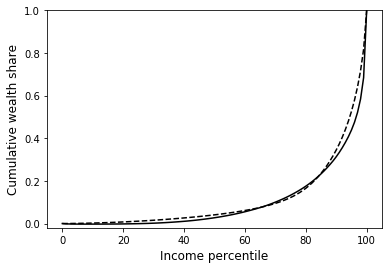

Estimate is center=0.9869173152693166, spread=0.0110844191673392
Lorenz distance is 2.170049033863157
Average MPC for all consumers is 0.272
Average MPC in the top percentile of W/Y is 0.039
Average MPC in the top decile of W/Y is 0.045
Average MPC in the top quintile of W/Y is 0.049
Average MPC in the second quintile of W/Y is 0.084
Average MPC in the middle quintile of W/Y is 0.242
Average MPC in the fourth quintile of W/Y is 0.381
Average MPC in the bottom quintile of W/Y is 0.605
Average MPC in the top percentile of y is 0.248
Average MPC in the top decile of y is 0.248
Average MPC in the top quintile of y is 0.255
Average MPC in the second quintile of y is 0.288
Average MPC in the middle quintile of y is 0.274
Average MPC in the fourth quintile of y is 0.240
Average MPC in the bottom quintile of y is 0.303
Average MPC for the employed is 0.260
Average MPC for the unemployed is 0.433
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
50.221% are in th

C:\Users\Tongli\Anaconda3\lib\site-packages\HARK\cstwMPC\cstwMPC.py:206: RuntimeWarning: invalid value encountered in double_scalars
  self.MPCunemployed = np.sum(MPCannual[unemployed]*CohortWeight[unemployed])/np.sum(CohortWeight[unemployed])
C:\Users\Tongli\Anaconda3\lib\site-packages\HARK\cstwMPC\cstwMPC.py:208: RuntimeWarning: invalid value encountered in double_scalars
  self.MPCretired    = np.sum(MPCannual[retired]*CohortWeight[retired])/np.sum(CohortWeight[retired])


KeyboardInterrupt: 

In [2]:
#Chosse the folder to save the output graphs
Folder_path='.'
# Set targets for K/Y and the Lorenz curve based on the data
lorenz_target = cstwMPC.getLorenzShares(Params.SCF_wealth,weights=Params.SCF_weights,percentiles=Params.percentiles_to_match)
lorenz_long_data = np.hstack((np.array(0.0),cstwMPC.getLorenzShares(Params.SCF_wealth,weights=Params.SCF_weights,percentiles=np.arange(0.01,1.0,0.01).tolist()),np.array(1.0)))
KY_target = 10.26

# Construct empty arrays for MPS and aggregate saving rate
MPS=[]
ASR=[]
AtoY=[]

# Do param-dist version if True, param-point if False
Params.do_param_dist=True

#search for spread_estimate and center estimate if true, use the given value if false
do_optimizing=False

# Define the agent type
BaselineType = cstwMPC.cstwMPCagent(**Params.init_infinite)

# Estimate Beta distribution
BaselineType.PermShkStd = [(0.01*4/11)**0.5]
BaselineType.ShkStd =[(0.01*4)**0.5]
cstwMPC.cstwMPCagent.updateIncomeProcess(BaselineType) # Crucial step for new PermShkStd value to be used 

# Key parameters of the agent type     
#BaselineType.CRRA = 2.0 
#BaselineType.LivPrb = [1.0 - 1.0/160.0] 
#BaselineType.Rfree = 1.01/BaselineType.LivPrb[0]
#BaselineType.PermGroFac = [1.000**0.25]
BaselineType.AgeDstn = np.array(1.0)

# Make agent types for estimation   
EstimationAgentList = []
for n in range(Params.pref_type_count):
    EstimationAgentList.append(deepcopy(BaselineType))
        
# Give all the AgentTypes different seeds
for j in range(len(EstimationAgentList)):
    EstimationAgentList[j].seed = j
    
# Make an economy for the consumers to live in
EstimationEconomy = cstwMPC.cstwMPCmarket(**Params.init_market)
EstimationEconomy.agents = EstimationAgentList
EstimationEconomy.KYratioTarget = KY_target
EstimationEconomy.LorenzTarget = lorenz_target
EstimationEconomy.LorenzData = lorenz_long_data
EstimationEconomy.PopGroFac = Params.PopGroFac
EstimationEconomy.TypeWeight = [1.0]
EstimationEconomy.act_T = Params.T_sim_PY
EstimationEconomy.ignore_periods = Params.ignore_periods_PY

#center_pre=0.9727332884459728  #result under the calibration of the baseline model
#spread_pre=0.03583373386250292  #result under the calibration of the baseline model
center_pre=0.9869173152693166 #result under the calibration of the QE paper G=1.015
spread_pre=0.0110844191673392 #result under the calibration of the QE paper G=1.015
#center_pre=0.9855570905831315  #result under the calibration of the QE paper 0.4
#spread_pre=0.015510492348684882  #result under the calibration of the QE paper 0.44

param_range = [0.9,0.999] #The optimal beta when cstwMPC is run with beta-dist and PermShkStd = [(0.02*4/11)**0.5]
spread_range = [0.005,0.03] #The optimal nabla when cstwMPC is run with beta-dist and PermShkStd = [(0.02*4/11)**0.5]

if do_optimizing:
    if Params.do_param_dist:
        # Run the param-dist estimation
        paramDistObjective = lambda spread : cstwMPC.findLorenzDistanceAtTargetKY(
                                                        Economy = EstimationEconomy,
                                                        param_name = Params.param_name,
                                                        param_count = Params.pref_type_count,
                                                        center_range = param_range,
                                                        spread = spread,
                                                        dist_type = Params.dist_type)
        t_start = clock()
        spread_estimate = golden(paramDistObjective,brack=spread_range,tol=1e-4)
        center_estimate = EstimationEconomy.center_save
        t_end = clock()
    else:
        # Run the param-point estimation only
        paramPointObjective = lambda center : cstwMPC.getKYratioDifference(Economy = EstimationEconomy,
                                              param_name = Params.param_name,
                                              param_count = Params.pref_type_count,
                                              center = center,
                                              spread = 0.0,
                                              dist_type = Params.dist_type)
        t_start = clock()
        center_estimate = brentq(paramPointObjective,param_range[0],param_range[1],xtol=1e-6)
        spread_estimate = 0.0
        t_end = clock()
        
        print(spread_estimate)
        print('****************')
        print(center_estimate)
        print('****************')
else:
    center_estimate=center_pre
    spread_estimate=spread_pre

#Display statistics about the estimated model
EstimationEconomy.LorenzBool = True
EstimationEconomy.ManyStatsBool = True
EstimationEconomy.distributeParams(Params.param_name,Params.pref_type_count,center_estimate,spread_estimate,Params.dist_type)
EstimationEconomy.center_estimate = center_estimate
EstimationEconomy.spread_estimate = spread_estimate

#Calculate the growth impatience factor of the most patient agent
R_GIC=BaselineType.Rfree*Params.LivPrb_i[0] #Interest rate we use to calculate GIC
ShockSample=np.random.lognormal(0.0,BaselineType.PermShkStd,10000000)
Inv_sample=1/ShockSample
Ex_psi_inv=1/(np.mean(Inv_sample))
Perm_Gro_em=Params.PermGroFac_i[0]*Params.PermGroFacAgg
GIC=(((R_GIC*EstimationEconomy.agents[(int(Params.pref_type_count)-1)].DiscFac)**(1/Params.CRRA))*Params.LivPrb_i[0])/(Perm_Gro_em*Ex_psi_inv)

print ('The growth impatience factor of the most patient agent is:' + str(GIC))

# Exercise conducted for a range of values for PermShkStd
for k in np.arange(0.005,0.021,0.001):   
    #print('**************************')
    #print(k)
    ShockStd = [(k*4)**0.5]   # standard deviation for permanent shock 
    BaselineType.PermShkStd = [(0.01*4/11)**0.5]
    BaselineType.TranShkStd =ShockStd
    #BaselineType.TranShkStd =[(0.01*4)**0.5]    
    for j in range(len(EstimationAgentList)):
        cstwMPC.cstwMPCagent.updateIncomeProcess(EstimationEconomy.agents[j]) 
    
    #Display statistics about the estimated model
    EstimationEconomy.LorenzBool = True
    EstimationEconomy.ManyStatsBool = True
    EstimationEconomy.distributeParams(Params.param_name,Params.pref_type_count,center_estimate,spread_estimate,Params.dist_type)
    EstimationEconomy.center_estimate = center_estimate
    EstimationEconomy.spread_estimate = spread_estimate
    for j in range(len(EstimationAgentList)):
        EstimationEconomy.agents[j].TranShkStd = ShockStd
    for j in range(len(EstimationAgentList)):
        cstwMPC.cstwMPCagent.updateIncomeProcess(EstimationEconomy.agents[j]) 
    
    #print ('Transitory Shock before is: ',EstimationEconomy.agents[1].TranShkStd)
    EstimationEconomy.solve()
    EstimationEconomy.calcLorenzDistance()
    #print ('Transitory Shock after is: ',EstimationEconomy.agents[1].TranShkStd)
    #print('***************************')
    #print('Estimate is center=' + str(center_estimate) + ', spread=' + str(spread_estimate) + ', took ' + str(t_end-t_start) + ' seconds.')
    EstimationEconomy.showManyStats(Params.spec_name)
    
    # Calculate and print variables of interest
    C_NrmNow=[]
    A_NrmNow=[]
    M_NrmNow=[]
    for j in range (len(EstimationAgentList)):
        C_NrmNow=np.hstack((C_NrmNow,EstimationEconomy.agents[j].cNrmNow))
    for j in range (len(EstimationAgentList)):
        A_NrmNow=np.hstack((A_NrmNow,EstimationEconomy.agents[j].aNrmNow))
    for j in range (len(EstimationAgentList)):
        M_NrmNow=np.hstack((M_NrmNow,EstimationEconomy.agents[j].mNrmNow))
    C=np.sum(np.hstack(EstimationEconomy.pLvlNow)*C_NrmNow) # Aggregate Consumption Level
    A=np.sum(np.hstack(EstimationEconomy.pLvlNow)*A_NrmNow) # Aggregate Assets
    M=np.sum(np.hstack(EstimationEconomy.pLvlNow)*M_NrmNow) # Aggregate Market Resources
    Y=np.sum(np.hstack(EstimationEconomy.pLvlNow)*np.hstack(EstimationEconomy.TranShkNow)) # Aggregate Labor Income
    B=M-Y 
    I=(BaselineType.Rfree-1)*B+Y # Aggregate Income
    SR=(I-C)/I # Aggregate Saving Rate
    MPSall=1-EstimationEconomy.MPCall # MPS
    AY=A/Y # Asset to Income Ratio
    print('A =',A)
    print('M =',M)
    print('Y =',Y)
    print('C =',C)
    print('SR =',SR)
    print('AY =',AY)
    #print(EstimationEconomy.AaggNow)
    #print(EstimationEconomy.AFunc)
    #print(np.sum(np.hstack(EstimationEconomy.aLvlNow)))

    # Construct an array for MPS and ASR to plot
    MPS.append(MPSall)
    ASR.append(SR)
    AtoY.append(AY)

#Plot the relationship between MPS/ASR and Std Dev of Perm Shk
std=(np.arange(0.005,0.021,0.001)*4)**0.5

Result_data_path = os.path.join(Folder_path,'SavingVSTranShr_Youth_MPC_15.png')
plt.ylabel('Aggregate Saving Rate')
plt.xlabel('Std Dev of Tran. Income Shock')
#plt.title('Change in Savings Following Increase in Permanent Income Uncertainty')
plt.ylim(0.08,0.16)
plt.scatter(std,ASR)
# Draw the linear fitted line
m, b = np.polyfit(std, ASR, 1)
plt.plot(std, m*std + b, '-')
plt.savefig(Result_data_path)
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(std,ASR)
print('Slope=' + str(slope) + ', intercept=' + str(intercept) + ', r_value=' + str(r_value) + ', p_value=' + str(p_value)+', std=' + str(std_err))
